In [3]:
# Standard imports.
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg.lapack as lapack

## Solve axisymmetric pipe flow (no-slip, steady)

In [4]:
def solve_pipe_poiseuille(R=1.0, n=201, G=1.0, nu=1.0):
    """
    Solve steady axisymmetric Poiseuille flow in a pipe:
        (1/r) d/dr ( r du/dr ) = -G/nu
    on r in [0, R] with:
        du/dr(0)=0  (symmetry)  -> enforced as u0 = u1
        u(R)=0      (no-slip)
    Returns: r, u
    """

    r = np.linspace(0.0, R, n)
    h = r[1] - r[0]

    A = np.zeros((n,n))
    b = np.zeros(n)

    # Centreline symmetry: u0 = u1
    A[0,0] = 1.0
    A[0,1] = -1.0
    b[0] = 0.0

    # Interior nodes 
    for i in range(1, n-1):
        ri = r[i]
        rip = ri + 0.5*h # r_{i+1/2}
        rim = ri - 0.5*h # r_{i-1/2}

        A[i,i-1] = rim / (ri*h*h)
        A[i,i] = -(rim + rip) / (ri*h*h)
        A[i, i+1] = rip / (ri*h*h)
        b[i] = -G/nu
    
    # No slip BC
    A[n-1, n-1] = 1.0
    b[n-1] = 0.0

    u = np.linalg.solve(A,b)
    return r, u

## Analytical solution + validation plot

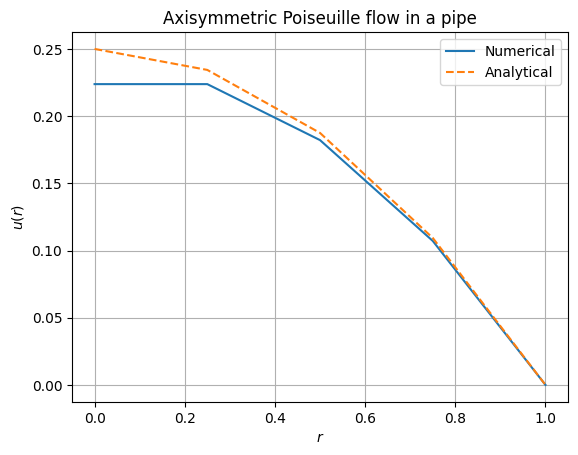

Max-norm error: 0.02619047619047621


In [5]:
R = 1.0
G = 1.0
nu = 1.0

r, u_num = solve_pipe_poiseuille(R=R, n=5, G=G, nu=nu)

u_ana = G/(4*nu)*(R**2 - r**2)

plt.figure()
plt.plot(r, u_num, label="Numerical")
plt.plot(r, u_ana, "--", label = "Analytical")
plt.xlabel(r"$r$")
plt.ylabel(r"$u(r)$")
plt.title("Axisymmetric Poiseuille flow in a pipe")
plt.grid(True)
plt.legend()
plt.show()

err_inf = np.max(np.abs(u_num - u_ana))
print("Max-norm error:", err_inf)

## Volume flux

Flux in cylindrical coordinates is,

$$
Q = 2\pi \int_0^R u(r) r dr, \qquad Q_{\text{ana}} = \frac{\pi GR^4}{8 \nu}
$$

In [6]:
Q_num = 2*np.pi * np.trapezoid(u_num * r, r)
Q_ana = (np.pi*G*R**4)/(8*nu)

print("Q_num=", Q_num)
print("Q_ana =", Q_ana)
print("Relative error =", abs(Q_num-Q_ana)/abs(Q_ana))

Q_num= 0.35716916478312527
Q_ana = 0.39269908169872414
Relative error = 0.09047619047619053


## Implement Navier slip for channel flow

Instead of the no slip boundary conditions, apply

$$
l \frac{\partial u}{\partial y} = \pm u \quad \text{at} \, \, y = \mp W
$$

In [7]:
def solve_channel_slip(W=1.0, n=101, G=1.0, nu=1.0, ell=0.0):
    """
    Solve -nu u'' = G on y in [-W, W]
    with Navier slip:
      u(-W) =  ell * u'(-W)
      u( W) = -ell * u'( W)
    (implemented with one-sided differences).
    """
    y = np.linspace(-W, W, n)
    h = y[1] - y[0]

    A = np.zeros((n, n))
    b = np.zeros(n)

    # Left wall (y=-W): (1+ell/h) u1 - (ell/h) u2 = 0
    A[0, 0] = 1.0 + ell/h
    A[0, 1] = -ell/h
    b[0] = 0.0

    # Interior: -nu (u_{i-1}-2u_i+u_{i+1})/h^2 = G
    for i in range(1, n-1):
        A[i, i-1] = -nu / h**2
        A[i, i]   =  2*nu / h**2
        A[i, i+1] = -nu / h**2
        b[i] = G

    # Right wall (y=+W): (1+ell/h) un - (ell/h) u_{n-1} = 0
    A[n-1, n-1] = 1.0 + ell/h
    A[n-1, n-2] = -ell/h
    b[n-1] = 0.0

    u = np.linalg.solve(A, b)
    return y, u

def u_analytic_channel_slip(y, W=1.0, G=1.0, nu=1.0, ell=0.0):
    return (G/(2*nu)) * (W**2 - y**2 + 2*W*ell)

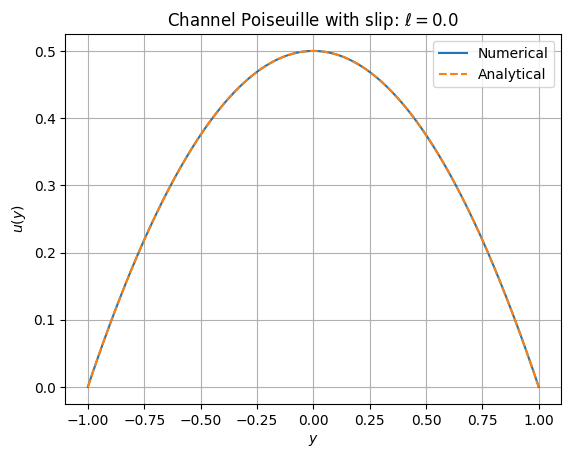

ell = 0.0 max error = 2.342849183244858e-12


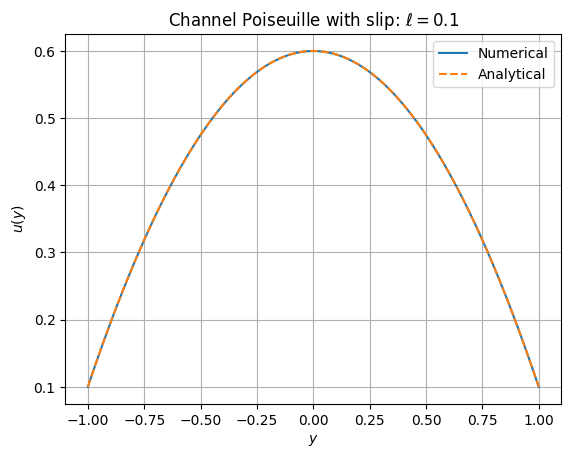

ell = 0.1 max error = 0.00012515644802646442


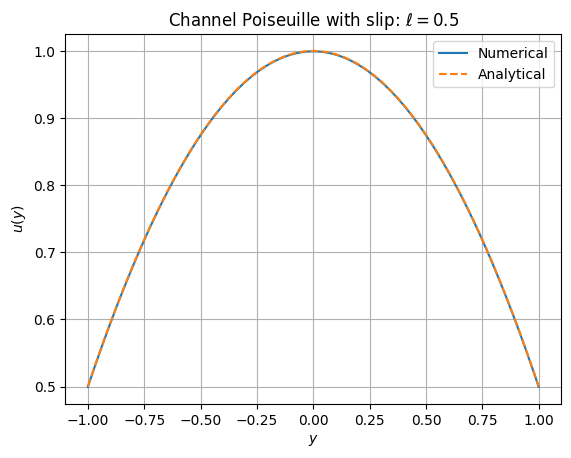

ell = 0.5 max error = 0.0006257822344514219


In [8]:
W, G, nu = 1.0, 1.0, 1.0
for ell in [0.0, 0.1, 0.5]:
    y, u_num = solve_channel_slip(W=W, n=800, G=G, nu=nu, ell=ell)
    u_ana = u_analytic_channel_slip(y, W=W, G=G, nu=nu, ell=ell)

    plt.figure()
    plt.plot(y, u_num, label="Numerical")
    plt.plot(y, u_ana, "--", label="Analytical")
    plt.title(fr"Channel Poiseuille with slip: $\ell={ell}$")
    plt.xlabel(r"$y$")
    plt.ylabel(r"$u(y)$")
    plt.grid(True)
    plt.legend()
    plt.show()

    print("ell =", ell, "max error =", np.max(np.abs(u_num - u_ana)))

## Volume flux with Navier slip

The analytical solution for the channel flow velocity profile with Navier slip boundary conditions is,

$$
u(y) = \frac{G}{2\nu}(W^2 - y^2 +2W\ell),
$$

and thus the analytical volume flux is 

$$
Q = \int_{-W}^W \frac{G}{2\nu}(W^2-y^2 + 2W\ell) \, dy = \frac{2G}{3\nu} W^3 + \frac{2G}{\nu}W^2 \ell.
$$

The numerical volume flux is 

$$
Q_{\text{num}} = \int_{-W}^W u(y) \, dy \approx \text{trapezoid}(u,y)
$$

In [9]:
W, G, nu = 1.0, 1.0, 1.0
for ell in [0.0, 0.1, 0.5]:
    y, u_num = solve_channel_slip(W=W, n=800, G=G, nu=nu, ell=ell)
    u_ana = u_analytic_channel_slip(y, W=W, G=G, nu=nu, ell=ell)
    Q_num = np.trapezoid(u_num, y)
    Q_ana = (2*G/(3*nu)) * W**3 + (2*G*ell/(nu)) * W**2
    print("ell =", ell)
    print("Q_num =", Q_num)
    print("Q_ana =", Q_ana)
    print("Relative error =", abs(Q_num - Q_ana)/abs(Q_ana))

ell = 0.0
Q_num = 0.6666656223903958
Q_ana = 0.6666666666666666
Relative error = 1.5664144061844354e-06
ell = 0.1
Q_num = 0.866415309497356
Q_ana = 0.8666666666666667
Relative error = 0.00029002750305078944
ell = 0.5
Q_num = 1.6654140579261671
Q_ana = 1.6666666666666665
Relative error = 0.0007515652442996235


## Implement Navier slip for pipe flow


In [10]:
def solve_pipe_poiseuille_navier_slip(R=1.0, n=201, G=1.0, nu=1.0, ell=0.0):
    """
    Steady axisymmetric Poiseuille flow in a circular pipe with Navier slip.

    Governing equation (for axial velocity u(r)):
        (1/r) d/dr ( r du/dr ) = -G/nu,   r in [0, R]

    Boundary conditions:
        symmetry at r=0: du/dr(0) = 0        (enforced as u0 = u1)
        Navier slip at r=R: ell * du/dr = -u (enforced with backward difference)
    """

    r = np.linspace(0.0, R, n)
    h = r[1] - r[0]

    A = np.zeros((n,n))
    b = np.zeros(n)

    # Centreline symmetry: u0 = u1
    A[0,0] = 1.0
    A[0,1] = -1.0
    b[0] = 0.0

    # Interior nodes 
    for i in range(1, n-1):
        ri = r[i]
        rip = ri + 0.5*h # r_{i+1/2}
        rim = ri - 0.5*h # r_{i-1/2}

        A[i,i-1] = rim / (ri*h*h)
        A[i,i] = -(rim + rip) / (ri*h*h)
        A[i, i+1] = rip / (ri*h*h)
        b[i] = -G/nu
    
    # Navier slip BC
    A[n-1, n-1] = 1.0 + ell/h
    A[n-1, n-2] = -ell/h
    b[n-1] = 0.0

    u = np.linalg.solve(A,b)
    return r, u

def u_analytic_pipe_slip(r, R=1.0, G=1.0, nu=1.0, ell=0.0):
    return (G/(4*nu)) * (R**2 - r**2 + 2*R*ell)

def flux_pipe(u, r):
    return 2 * np.pi * np.trapezoid(u * r, r)

ell = 0.0


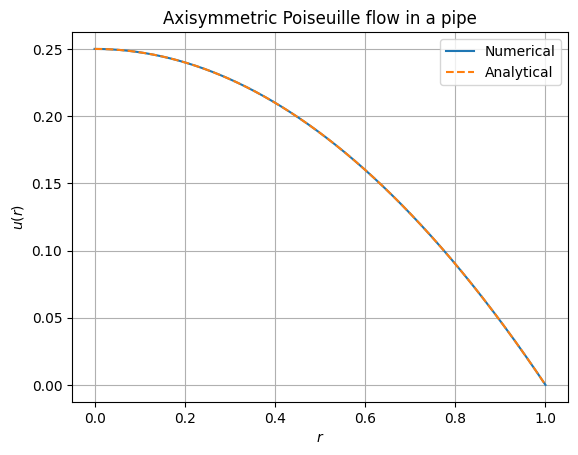

Q_num = 0.3926981590068508
Q_ana = 0.39269908169872414
Relative error = 2.3496155615117607e-06
ell = 0.1


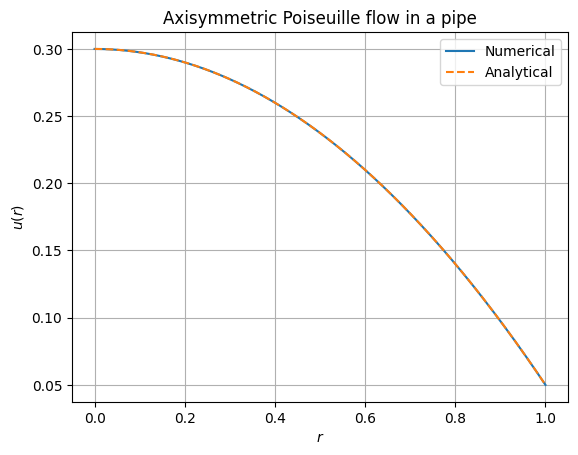

Q_num = 0.5496794324922962
Q_ana = 0.5497787143782138
Relative error = 0.0001805851760373326
ell = 0.5


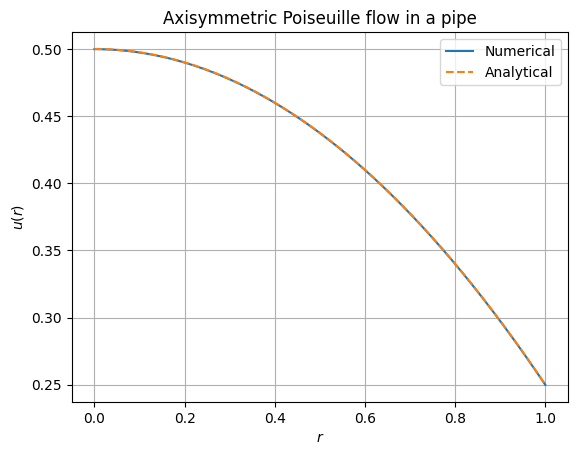

Q_num = 1.1776045264334378
Q_ana = 1.1780972450961724
Relative error = 0.0004182325905484739


In [11]:
R, G, nu = 1.0, 1.0, 1.0
for ell in [0.0, 0.1, 0.5]:
    r, u_num = solve_pipe_poiseuille_navier_slip(R=R, n=800, G=G, nu=nu, ell=ell)
    u_ana = u_analytic_pipe_slip(r, R=R, G=G, nu=nu, ell=ell)
    print("ell =", ell)

    plt.figure()
    plt.plot(r, u_num, label="Numerical")
    plt.plot(r, u_ana, "--", label = "Analytical")
    plt.xlabel(r"$r$")
    plt.ylabel(r"$u(r)$")
    plt.title("Axisymmetric Poiseuille flow in a pipe")
    plt.grid(True)
    plt.legend()
    plt.show()

    Q_num = flux_pipe(u_num, r)
    Q_ana = (np.pi*G/(8*nu)) * (R**4 + 4*R**3*ell)
    print("Q_num =", Q_num)
    print("Q_ana =", Q_ana)
    print("Relative error =", abs(Q_num - Q_ana)/abs(Q_ana))

## Plots for Results and Discussion


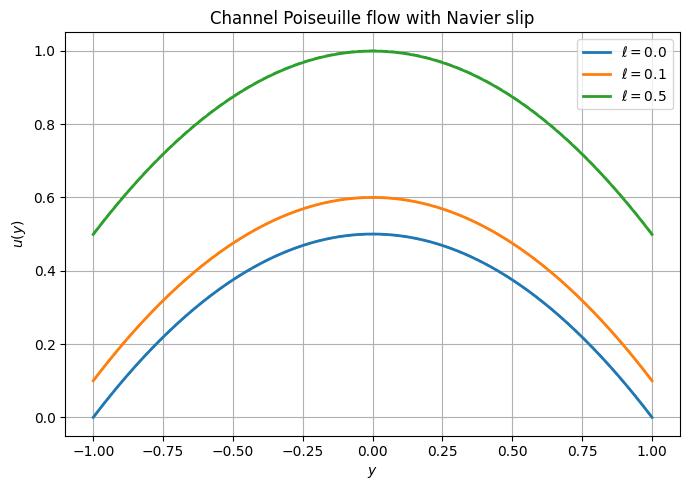

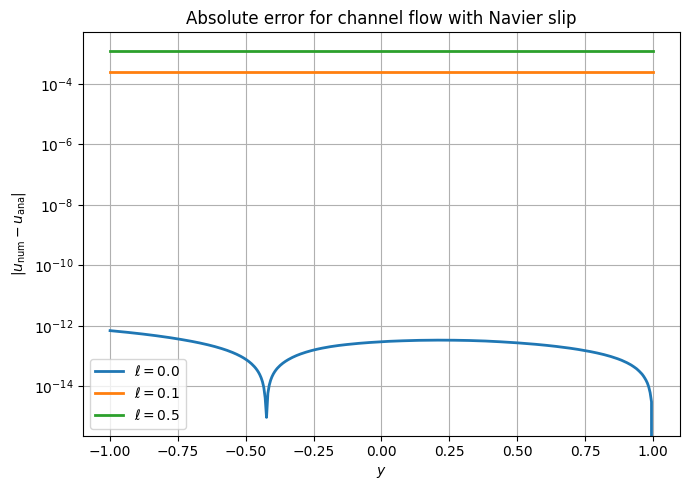

In [12]:
W, G, nu = 1.0, 1.0, 1.0
ells = [0.0, 0.1, 0.5]

# --- Define a consistent colour map for slip lengths ---
colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]
ell_colors = {ell: colors[i] for i, ell in enumerate(ells)}

# ===============================
# Figure 1: Velocity profiles
# ===============================
plt.figure(figsize=(7,5))

for ell in ells:
    y, u_num = solve_channel_slip(W=W, n=400, G=G, nu=nu, ell=ell)
    u_ana = u_analytic_channel_slip(y, W=W, G=G, nu=nu, ell=ell)

    c = ell_colors[ell]
    plt.plot(y, u_num, lw=2, color=c, label=fr"$\ell={ell}$")
    plt.plot(y, u_ana, "--", lw=1.5, color=c)

plt.xlabel(r"$y$")
plt.ylabel(r"$u(y)$")
plt.title("Channel Poiseuille flow with Navier slip")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# ===============================
# Figure 2: Absolute error
# ===============================
plt.figure(figsize=(7,5))

for ell in ells:
    y, u_num = solve_channel_slip(W=W, n=400, G=G, nu=nu, ell=ell)
    u_ana = u_analytic_channel_slip(y, W=W, G=G, nu=nu, ell=ell)

    err = np.abs(u_num - u_ana)
    plt.plot(y, err, lw=2, color=ell_colors[ell], label=fr"$\ell={ell}$")

plt.xlabel(r"$y$")
plt.ylabel(r"$|u_{\mathrm{num}}-u_{\mathrm{ana}}|$")
plt.yscale("log")
plt.title("Absolute error for channel flow with Navier slip")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

### Pipe flow plots

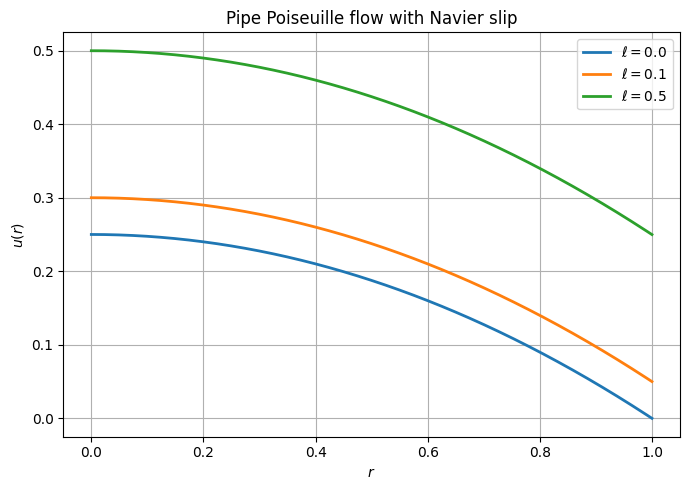

ell=0.0: max error = 1.693e-06
ell=0.1: max error = 3.300e-05
ell=0.5: max error = 1.582e-04


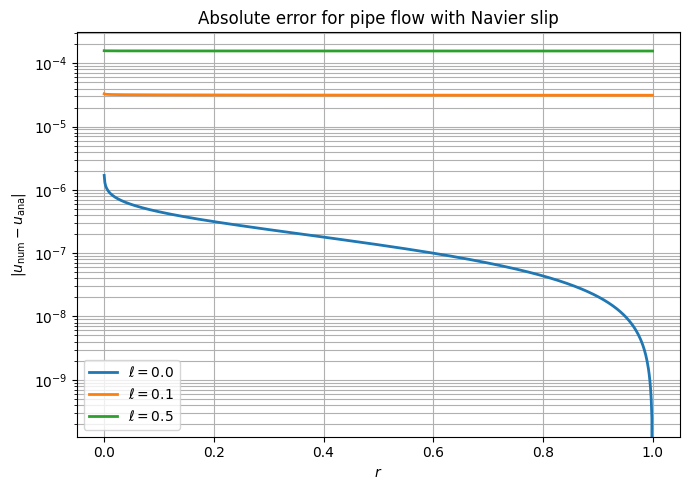

In [18]:
R, G, nu = 1.0, 1.0, 1.0
ells = [0.0, 0.1, 0.5]
n = 800

# consistent colours across figures
colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]
ell_colors = {ell: colors[i] for i, ell in enumerate(ells)}

plt.figure(figsize=(7,5))

for ell in ells:
    r, u_num = solve_pipe_poiseuille_navier_slip(R=R, n=n, G=G, nu=nu, ell=ell)
    plt.plot(r, u_num, lw=2, color=ell_colors[ell], label=fr"$\ell={ell}$")

plt.xlabel(r"$r$")
plt.ylabel(r"$u(r)$")
plt.title("Pipe Poiseuille flow with Navier slip")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(7,5))

for ell in ells:
    r, u_num = solve_pipe_poiseuille_navier_slip(R=R, n=n, G=G, nu=nu, ell=ell)
    u_ana = u_analytic_pipe_slip(r, R=R, G=G, nu=nu, ell=ell)

    err = np.abs(u_num - u_ana)
    plt.plot(r, err, lw=2, color=ell_colors[ell], label=fr"$\ell={ell}$")

    print(f"ell={ell}: max error = {np.max(err):.3e}")

plt.xlabel(r"$r$")
plt.ylabel(r"$|u_{\mathrm{num}}-u_{\mathrm{ana}}|$")
plt.yscale("log")
plt.title("Absolute error for pipe flow with Navier slip")
plt.grid(True, which="both")
plt.legend()
plt.tight_layout()
plt.show()

### Grid convergence test


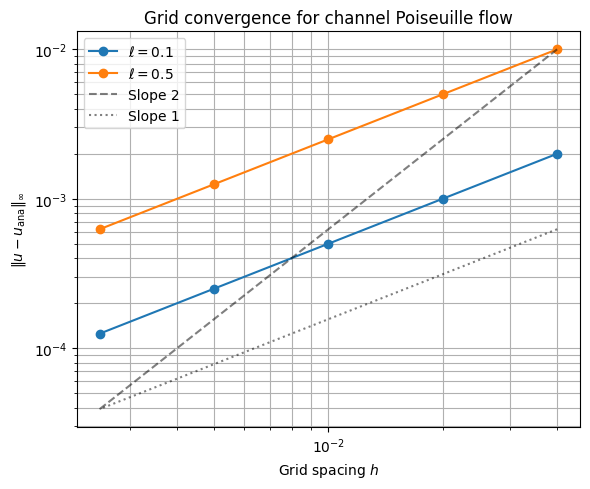

In [14]:
W, G, nu = 1.0, 1.0, 1.0
ells = [0.1, 0.5]          # no-slip and one slip case
ns = [51, 101, 201, 401, 801]

plt.figure(figsize=(6,5))

for ell in ells:
    errs = []
    hs = []

    for n in ns:
        y, u_num = solve_channel_slip(W=W, n=n, G=G, nu=nu, ell=ell)
        u_ana = u_analytic_channel_slip(y, W=W, G=G, nu=nu, ell=ell)

        err_inf = np.max(np.abs(u_num - u_ana))
        errs.append(err_inf)
        hs.append(2*W/(n-1))

    plt.loglog(
        hs, errs, "o-",
        label=fr"$\ell={ell}$"
    )

# Reference slopes
h_ref = np.array(hs)
plt.loglog(h_ref, h_ref**2 / h_ref[0]**2 * errs[0], "k--", alpha=0.5, label="Slope 2")
plt.loglog(h_ref, h_ref / h_ref[0] * errs[-1], "k:", alpha=0.5, label="Slope 1")

plt.xlabel(r"Grid spacing $h$")
plt.ylabel(r"$\|u-u_{\mathrm{ana}}\|_\infty$")
plt.title("Grid convergence for channel Poiseuille flow")
plt.grid(True, which="both")
plt.legend()
plt.tight_layout()
plt.show()

### Volume flux plots

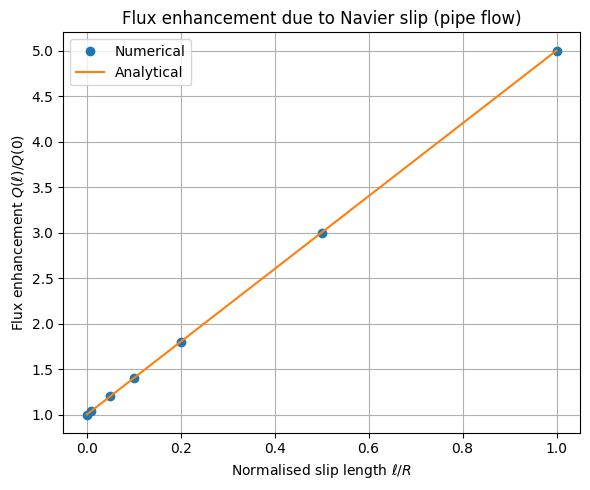

In [22]:
# Parameters
R, G, nu = 1.0, 1.0, 1.0
n = 800

# Slip lengths to sample (log-spaced is clean and informative)
ells = np.array([0.0, 0.01, 0.05, 0.1, 0.2, 0.5, 1.0])

Q_num = []
Q_ana = []

for ell in ells:
    r, u_num = solve_pipe_poiseuille_navier_slip(
        R=R, n=n, G=G, nu=nu, ell=ell
    )
    Q_num.append(flux_pipe(u_num, r))

    # Analytical flux for pipe flow with Navier slip
    Q_ana.append((np.pi * G / (8 * nu)) * (R**4 + 4 * R**3 * ell))

Q_num = np.array(Q_num)
Q_ana = np.array(Q_ana)

# Normalise by no-slip flux
Q0 = Q_ana[0]

# Plot
plt.figure(figsize=(6,5))
plt.plot(ells / R, Q_num / Q0, "o", label="Numerical")
plt.plot(ells / R, Q_ana / Q0, "-", label="Analytical")

plt.xlabel(r"Normalised slip length $\ell/R$")
plt.ylabel(r"Flux enhancement $Q(\ell)/Q(0)$")
plt.title("Flux enhancement due to Navier slip (pipe flow)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()